# PINN Solution of the Gray Scott PDEs

This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Gray Scott PDEs with periodic boundary condition
\begin{aligned}
  &u_t = \Delta u + b(1 - u) - uv^2, \quad (t, x) \in [0, T]\times[-L, L]\\
  &v_t = \Delta v -dv + uv^2, \\
  &u(0, x) = u_0(x), \quad v(0, x) = v_0(x), \quad \forall x \in [-L, L] \\
  &u(t, -L) = u_{left}(t), u(t, L) = u_{right}(t), \quad v(t, -L) = v_{left}(t), v(t, L) = v_{right}(t), \quad \forall t \in [0, T]
\end{aligned}
where $b, d > 0$ are some parameters, and $[-L, L]$ covers one full period.

When $b = F$ and $d = F + K$ and $4(F + K)^2 < F$, then the PDEs can be transformed into a boundary value problem of ODES with $z = x - \beta t$ with 
$$
\beta = \frac{\sqrt{2}}{4}(1 - 3\sqrt{\eta}) \quad \text{and} \quad \eta = 1 - 4F
$$
Then
\begin{aligned}
-\beta\frac{du}{dz} &= \frac{d^2u}{dz^2} + F(1 - u) - uv^2\\
-\beta\frac{dv}{dz} &= \frac{d^2v}{dz^2} - (F + K)v + uv^2\\
\end{aligned}
(Please check this transformation).  With the boundary value
$$
\begin{bmatrix} u \\ v \end{bmatrix}(-10) = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \quad \text{and} \quad \begin{bmatrix} u \\ v \end{bmatrix}(-10) = \begin{bmatrix} \frac{2 + \sqrt{2}}{4} \\ \frac{2 - \sqrt{2}}{4} \end{bmatrix}
$$
then the true solutions are
\begin{aligned}
u &= \frac{3 - \sqrt{\eta}}{4} - \frac{2\sqrt{\xi}}{4}\tanh(\frac{\sqrt{\xi}}{4}z) \\
v &= \frac{1 + \sqrt{\eta}}{4} + \frac{2\sqrt{\xi}}{4}\tanh(\frac{\sqrt{\xi}}{4}z) 
\end{aligned}
(Please also check)

See [this link](https://amses-journal.springeropen.com/articles/10.1186/s40323-022-00219-7) for a description

## Libraries and Dependencies

In [1]:
import torch
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# set the random seed
# np.random.seed(1234)

In [2]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean       # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

In [3]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": r"\usepackage[utf8x]{inputenc} \usepackage[T1]{fontenc}"
    # use utf8 fonts becasue your computer can handle it :)
    # plots will be generated using this preamble
    }
mpl.rcParams.update(pgf_with_latex)

In [4]:
# MPS or CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [5]:
"""
Problem Definition
"""
# define grid for quadrature solution
F = 1.0/8.0
# need 4(F + K)^2 < F
K = 0.0
eta = 1.0 - 4.0 * F
beta = np.sqrt(2.0)/4.0 * (1.0 - 3.0 * np.sqrt(eta))
xi = 1.0 + np.sqrt(eta) - 2.0 * F
b = F
d = F + K
L = 10.0
zlo = -L
zhi = L
u_a = 1.0
v_a = 0.0
u_b = (2.0 - np.sqrt(2.0))/4.0
v_b = (2.0 + np.sqrt(2.0))/4.0
# true solutions
u_true = lambda z: (3.0 - np.sqrt(eta))/4.0 - np.sqrt(2.0 * xi)/4.0 * np.tanh(np.sqrt(xi)/4.0 * z)
v_true = lambda z: (1.0 + np.sqrt(eta))/4.0 + np.sqrt(2.0 * xi)/4.0 * np.tanh(np.sqrt(xi)/4.0 * z)

## Physics-informed Neural Networks

In [6]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Sigmoid
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    def forward(self, x):
        out = self.layers(x)
        return out

In [7]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, z_data, u_data, v_data, z_ode, layers, beta, b, d):
        # data (Dirichlet BC data)
        self.z_data = torch.tensor(z_data).float().to(device)
        self.u_data = torch.tensor(u_data).float().to(device)
        self.v_data = torch.tensor(v_data).float().to(device)
        # ODE data, gradients will be computed on these points so requires_grad = True
        self.z_ode = torch.tensor(z_ode, requires_grad=True).float().to(device)
        # layers for constructive Neural Net
        self.layers = layers
        # equation related parameters
        self.beta = beta
        self.b = b
        self.d = d
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        # set up the optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-2)
        self.Adam_tol = 1e-3
    # evaluater neural network
    def NN_eval(self, z):  
        NN = self.dnn(z)
        u = NN[:, 0][:, None]
        v = NN[:, 1][:, None]
        return u, v
    # compute the PDE
    def pde_eval(self, z):
        """ The pytorch autograd version of calculating residual """
        u, v = self.NN_eval(z)
        # compute the derivatives for u
        u_z  = torch.autograd.grad(u,   z, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_zz = torch.autograd.grad(u_z, z, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        v_z  = torch.autograd.grad(v,   z, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        v_zz = torch.autograd.grad(v_z, z, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        Eq1 = self.beta * u_z + u_zz + self.b * (1.0 - u) - u * torch.pow(v, 2.0)
        Eq2 = self.beta * v_z + v_zz - self.d * v + u * torch.pow(v, 2.0)
        return Eq1, Eq2
    # compute the total loss for the second-order optimizer
    def loss_func(self):
        # reset the gradient
        self.optimizer.zero_grad()
        # compute the data loss
        u_pred, v_pred = self.NN_eval(self.z_data)
        loss_data = torch.mean((self.u_data - u_pred)**2.0) + torch.mean((self.v_data - v_pred)**2.0)
        # compute ODE loss
        ode1_pred, ode2_pred = self.pde_eval(self.z_ode)
        loss_ode = torch.mean(ode1_pred ** 2) + torch.mean(ode2_pred ** 2)
        # compute the total loss, it can be weighted
        loss = loss_data + loss_pde
        # backward propagation
        loss.backward()
        # increase the iteration counter
        self.iter += 1
        # output
        if (self.iter + 1) % 1000 == 0:
            print(
                'Iter %5d, Total: %10.4e, Data: %10.4e, ODE: %10.4e' 
                % (self.iter + 1, loss.item(), loss_data.item(), loss_ode.item())
            )           
        return loss
    #
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            # compute the data loss
            u_pred, v_pred = self.NN_eval(self.z_data)
            loss_data = torch.mean((self.u_data - u_pred)**2.0) + torch.mean((self.v_data - v_pred)**2.0)
            # compute ODE loss
            ode1_pred, ode2_pred = self.pde_eval(self.z_ode)
            loss_ode = torch.mean(ode1_pred ** 2) + torch.mean(ode2_pred ** 2)
            # compute the total loss, it can be weighted
            loss = loss_data + loss_ode
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()           
            # output the progress
            if epoch == 0:
                loss_prev = loss.item()
            if (epoch + 1) % 1000 == 0:
                loss_curr = loss.item()
                print(
                    'Iter %5d, Total: %10.4e, Data: %10.4e, ODE: %10.4e' 
                    % (epoch + 1, loss_curr, loss_data.item(), loss_ode.item())
                )          
                if (loss_prev != 0) and (np.abs(loss_curr - loss_prev)/loss_prev < self.Adam_tol):
                    print('Stopping at epoch = %5d' % (epoch))
                    break
    #        
    def predict(self, z):
        z_torch = torch.tensor(z, requires_grad=True).float().to(device)
        self.dnn.eval()
        u, v = self.NN_eval(z_torch)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        return u, v

## Configurations

In [8]:
N_BC = 2
N_ODE = 21
# where we know the data
# BC at z = -10 and z = 10
# IC: t = 0, x \in [xlo, xhi], it can be on a gridd or random
# make sure they are all column vectors, which is a 2-dim tensor
zBC = np.expand_dims(np.array([zlo, zhi]), axis = 1)
uBC = np.expand_dims(np.array([u_a, u_b]), axis = 1)
vBC = np.expand_dims(np.array([v_a, v_b]), axis = 1)
# collocation points for PDE loss
pts_ODE = lhs(1, N_ODE)
# transform it back to proper range
z_ode = zlo + (zhi - zlo) * pts_ODE[:, 0:1]

## Training

In [9]:
layers = [1, 10, 10, 20, 20, 2]
model = PhysicsInformedNN(zBC, uBC, vBC, z_ode, layers, beta, b, d)

In [10]:
%%time
model.train(50000)

Iter  1000, Total: 2.0893e-06, Data: 2.8185e-08, ODE: 2.0611e-06
Iter  2000, Total: 1.2971e-06, Data: 6.0576e-08, ODE: 1.2365e-06
Iter  3000, Total: 8.1483e-07, Data: 4.9370e-08, ODE: 7.6546e-07
Iter  4000, Total: 4.3684e-07, Data: 3.4530e-08, ODE: 4.0231e-07
Iter  5000, Total: 4.5276e-07, Data: 6.1780e-08, ODE: 3.9098e-07
Iter  6000, Total: 3.9044e-07, Data: 5.1725e-08, ODE: 3.3871e-07
Iter  7000, Total: 3.6834e-07, Data: 5.4461e-08, ODE: 3.1388e-07
Iter  8000, Total: 4.3136e-07, Data: 2.0704e-07, ODE: 2.2432e-07
Iter  9000, Total: 2.3199e-07, Data: 2.7920e-08, ODE: 2.0407e-07
Iter 10000, Total: 1.9947e-07, Data: 2.3770e-08, ODE: 1.7570e-07
Iter 11000, Total: 2.4328e-07, Data: 8.8263e-08, ODE: 1.5501e-07
Iter 12000, Total: 1.4111e-07, Data: 1.9687e-08, ODE: 1.2142e-07
Iter 13000, Total: 3.9088e-05, Data: 3.7155e-05, ODE: 1.9331e-06
Iter 14000, Total: 3.4670e-06, Data: 3.2177e-06, ODE: 2.4931e-07
Iter 15000, Total: 6.9746e-07, Data: 4.1216e-07, ODE: 2.8530e-07
Iter 16000, Total: 1.2699

KeyboardInterrupt: 

In [13]:
# apply PINN to the same grid as the quadrature solution for comparison
z = np.expand_dims(np.linspace(zlo, zhi, 600), axis = 1)
u_pred, v_pred = model.predict(z)
#
u_exact = u_true(z)
v_exact = v_true(z)
#

## Visualizations

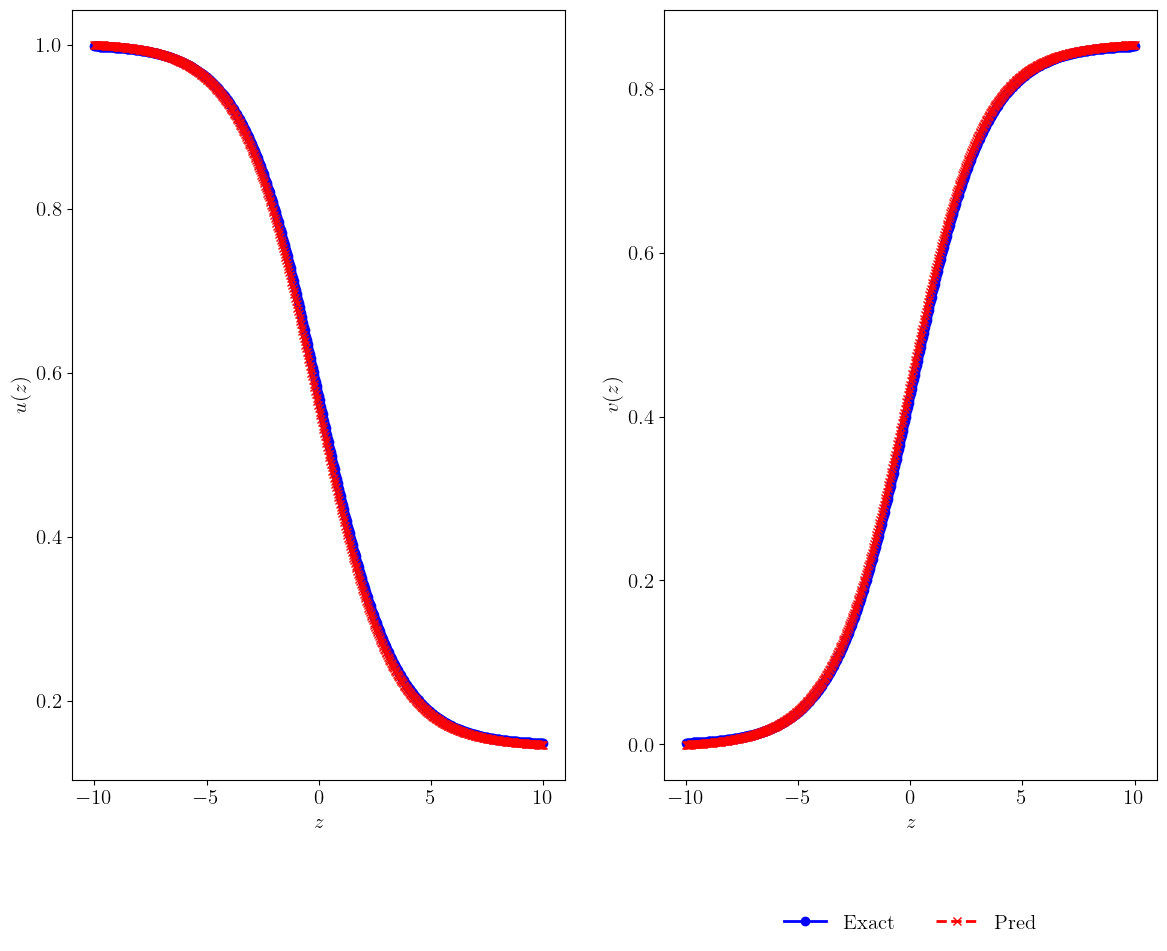

In [14]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
#
ax = plt.subplot(1, 2, 1)
ax.plot(z, u_exact, 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(z, u_pred, 'rx--', linewidth = 2, label = 'Pred')
ax.set_xlabel('$z$')
ax.set_ylabel('$u(z)$') 
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#
ax = plt.subplot(1, 2, 2)
ax.plot(z, v_exact, 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(z, v_pred, 'rx--', linewidth = 2, label = 'Pred')
ax.set_xlabel('$z$')
ax.set_ylabel('$v(z)$') 
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#
plt.show()